# 2021-09-10 Chebyshev collocation

## Last time
* Hands-on/discussion of Dirichlet and Neumann boundary conditions

## Today

* Conditioning and stability of polynomial interpolation
* Runge Phenomenon
* Chebyshev differentiation
* Chebyshev-based solver for the Poisson problem

In [2]:
using Plots
using LinearAlgebra

function vander(x, k=nothing)
    if k === nothing
        k = length(x)
    end
    V = ones(length(x), k)
    for j = 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function fdstencil(source, target, k)
    "kth derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    rhs = zero(x)'
    rhs[k+1] = factorial(k)
    rhs / V
end


function poisson(x, spoints, forcing; left=(0, zero), right=(0, zero))
    n = length(x)
    L = zeros(n, n)
    rhs = forcing.(x)
    for i in 2:n-1
        jleft = min(max(1, i-spoints÷2), n-spoints+1)
        js = jleft : jleft + spoints - 1
        L[i, js] = -fdstencil(x[js], x[i], 2)
    end
    L[1,1:spoints] = fdstencil(x[1:spoints], x[1], left[1])
    L[n,n-spoints+1:n] = fdstencil(x[n-spoints+1:n], x[n], right[1])
    rhs[1] = left[2](x[1])
    rhs[n] = right[2](x[n])
    L, rhs
end

poisson (generic function with 1 method)

# Visualizing matrix transformations

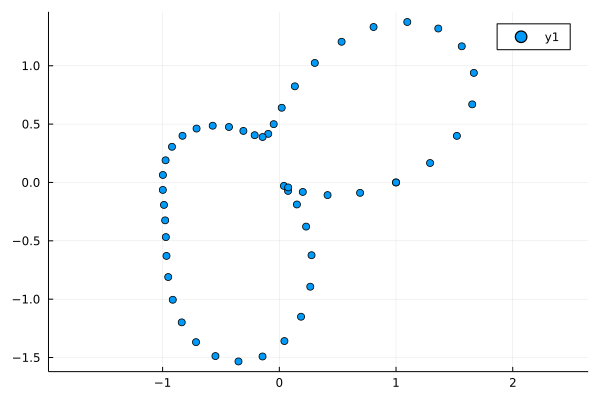

In [179]:
function peanut()
    theta = LinRange(0, 2*pi, 50)
    r = 1 .+ .4*sin.(3*theta) + .6*sin.(2*theta)
    x = r .* cos.(theta)
    y = r .* sin.(theta)
    x, y
end
x, y = peanut()
scatter(x, y, aspect_ratio=:equal)

Group these points into a $2\times n$ matrix $X$. Note that multiplication by any matrix $A$ is applied to each column separately, i.e.,

$$ A \underbrace{\Bigg[ \mathbf x_1 \Bigg| \mathbf x_2 \Bigg| \dotsb \Bigg]}_X = \Bigg[ A \mathbf x_1 \Bigg| A \mathbf x_2 \Bigg| \dotsb \Bigg] $$

In [180]:
X = [x y]'
size(X)

(2, 50)

# Visualizing the Singular Value Decomposition

2-element Vector{Float64}:
 1.0579468242585781
 0.16252130662509728

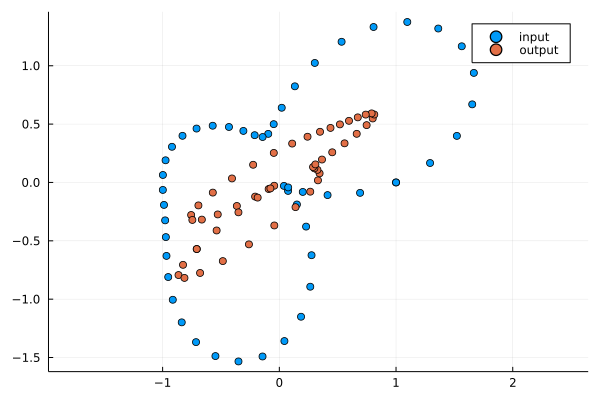

In [188]:
function tplot(A)
    x, y = peanut()
    X = [x y]'
    Y = A * X
    scatter(X[1,:], X[2,:], label="input", aspect_ratio=:equal)
    scatter!(Y[1,:], Y[2,:], label="output")
end

A = randn(2, 2)
display(svdvals(A))
tplot(A)

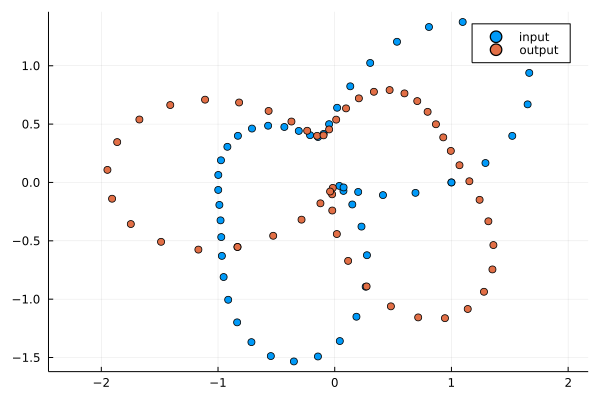

In [192]:
U, S, V = svd(A)
tplot(U)

# Condition number of interpolation

In [200]:
n = 20
source = LinRange(-1, 1, n)
target = LinRange(-1, 1, 100)
P = vander(source)
A = vander(target, n) / P
svdvals(A)

20-element Vector{Float64}:
 4141.821782242258
  756.1886115511251
   11.201394439549022
    5.200366811388276
    2.3263899155788184
    2.2886531575729756
    2.2826626548130866
    2.2826582312601693
    2.282657730773899
    2.2826577307583387
    2.282657729732408
    2.2826577141930864
    2.2825938632314635
    2.2823522003466126
    2.248454974008582
    2.2449230243848635
    1.9014541632797317
    1.7794033223590953
    1.0093167855418923
    1.0064482710880027

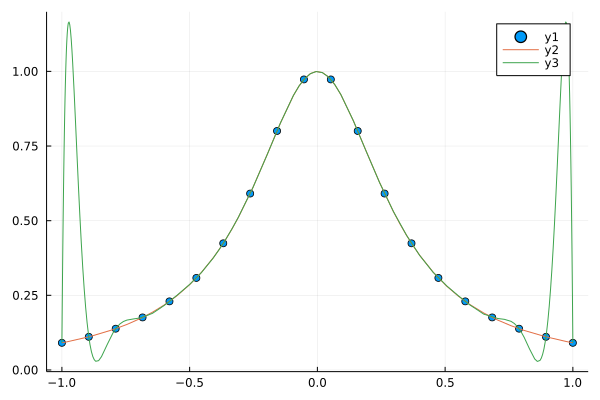

In [201]:
runge(x) = 1 / (1 + 10*x^2)
y = runge.(source)
scatter(source, y)
plot!([runge,
        x -> (vander([x], n) / P * y)[1]])
# plot!(target, A * y)

# The bad singular vectors

$$ A = U \Sigma V^T $$


In [202]:
n = 11
source = LinRange(-1, 1, n)
target = LinRange(-1, 1, 100)
P = vander(source)
A = vander(target, n) / P
U, S, V = svd(A)
S

11-element Vector{Float64}:
 34.77706851205646
 11.13125653860815
  3.2006228235799146
  3.155189114518782
  3.146427056066729
  3.146390542844362
  3.1459494752515185
  2.900733962570112
  2.700731526422513
  1.2170432449283035
  1.1628054393968779

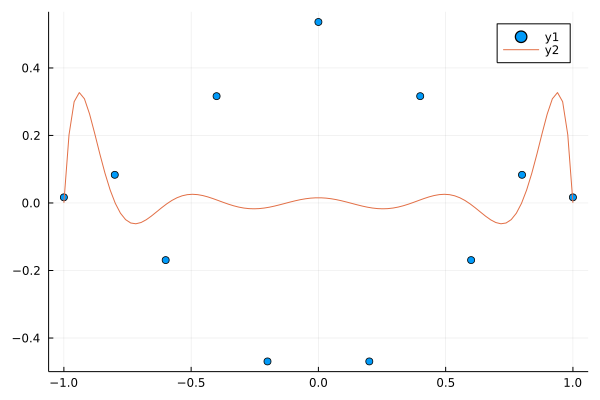

In [207]:
scatter(source, V[:,1])
plot!(target, U[:,1])

# Choosing the source points

In [44]:
CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

CosRange (generic function with 1 method)

In [210]:
n = 15
source = CosRange(-1, 1, n)
target = LinRange(-1, 1, 100)
P = vander(source)
A = vander(target, n) / P
svdvals(A)

15-element Vector{Float64}:
 3.3224452579600543
 3.2951489624388866
 3.2390224008180537
 3.181109040401762
 3.0703313983113376
 2.9872800167945326
 2.8121577830547233
 2.705974980412334
 2.458141299101599
 2.3201773057791897
 2.01732010538979
 1.790374810469325
 1.5900555135937617
 1.0373676954022644
 1.0310696201759286

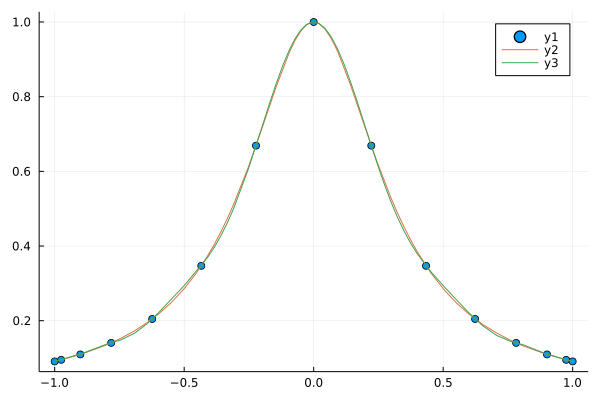

In [211]:
runge(x) = 1 / (1 + 10*x^2)
y = runge.(source)
scatter(source, y)
plot!([runge,
        x -> (vander([x], n) / P * y)[1]])

# Condition number of interpolation on `CosRange` points

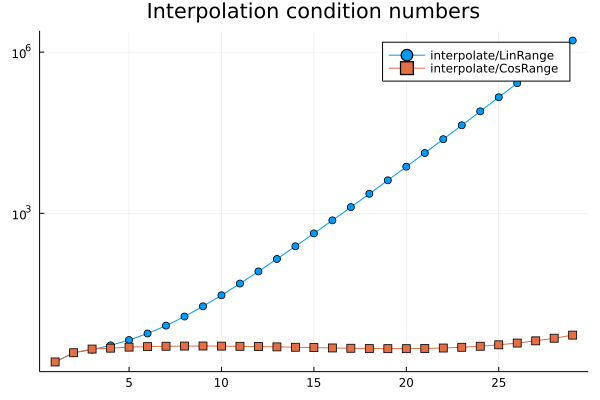

In [212]:
interpolate(source, target=LinRange(-1, 1, 100)) = vander(target, length(source)) / vander(source)

plot_cond(mat, points) = plot!([
        cond(mat(points(-1, 1, n)))
        for n in 2:30], label="$mat/$points", marker=:auto, yscale=:log10)

plot(title="Interpolation condition numbers")
plot_cond(interpolate, LinRange)
plot_cond(interpolate, CosRange)

# Vandermonde conditioning, stable algorithms

It is possible for interpolation to be well-conditioned, but construct it from ill-conditioned pieces.

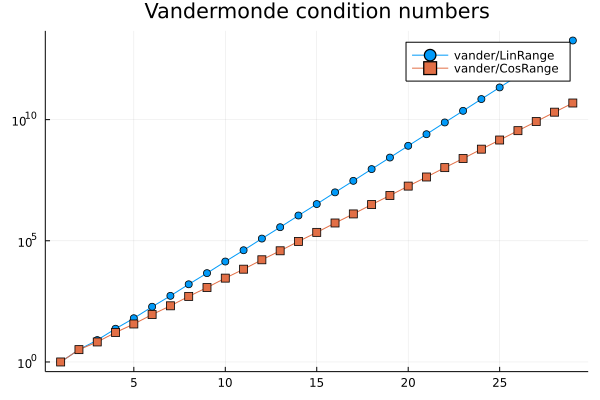

In [58]:
plot(title="Vandermonde condition numbers")
plot_cond(vander, LinRange)
plot_cond(vander, CosRange)

# Chebyshev polynomials

In [59]:
function vander_chebyshev(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    T = ones(m, n)
    if n > 1
        T[:, 2] = x
    end
    for k in 3:n
        T[:, k] = 2 * x .* T[:,k-1] - T[:, k-2]
    end
    T
end

vander_chebyshev (generic function with 2 methods)

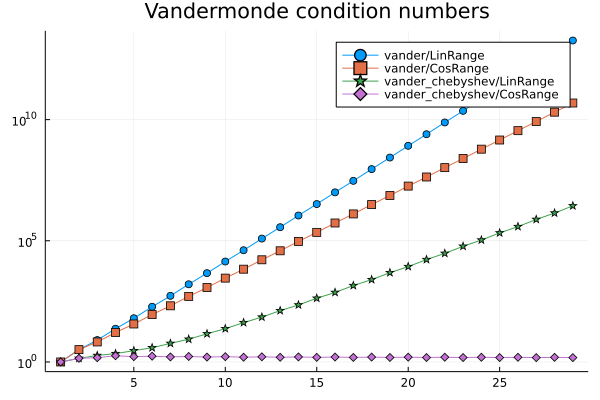

In [60]:
plot(title="Vandermonde condition numbers")
plot_cond(vander, LinRange)
plot_cond(vander, CosRange)
plot_cond(vander_chebyshev, LinRange)
plot_cond(vander_chebyshev, CosRange)

# Derivation of Chebyshev polynomials (supplemental)

Chebyshev polynomials are defined for non-negative integar $n$ as $$ T_n(x) = \cos (n \arccos(x)) .$$
This turns out to be a polynomial, but it's not obvious why.
Recall $$ \cos(a + b) = \cos a \cos b - \sin a \sin b .$$
Let $y = \arccos x$ and check
$$ \begin{split}
    T_{n+1}(x) &= \cos \big( (n+1) y \big) = \cos ny \cos y - \sin ny \sin y \\
    T_{n-1}(x) &= \cos \big( (n-1) y \big) = \cos ny \cos y + \sin ny \sin y
\end{split}$$
Adding these together produces
$$ T_{n+1}(x) + T_{n-1}(x) = 2\cos ny \cos y = 2 x \cos ny = 2 x T_n(x) $$
which yields a convenient recurrence:
$$\begin{split}
T_0(x) &= 1 \\
T_1(x) &= x \\
T_{n+1}(x) &= 2 x T_n(x) - T_{n-1}(x)
\end{split}$$

# Lagrange interpolating polynomials

Find the unique polynomial that is 0 at all but one `source` point.

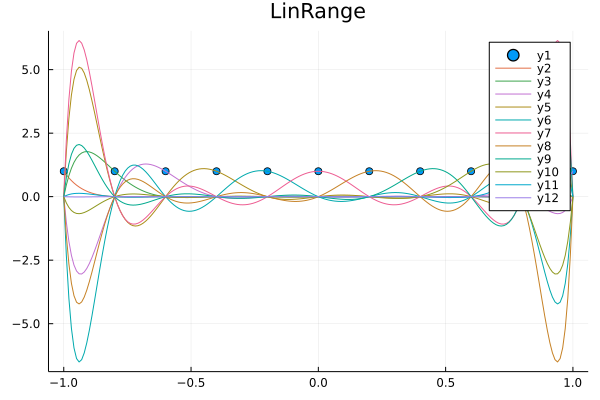

In [213]:
source = LinRange(-1, 1, 11)
target = LinRange(-1, 1, 200)
scatter(source, one.(source), title="LinRange")
plot!(target, interpolate(source, target))

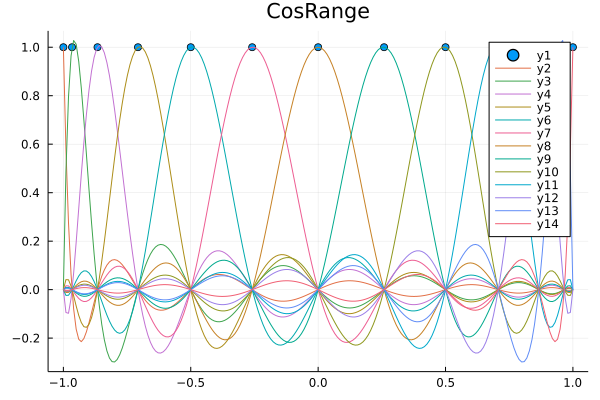

In [214]:
source = CosRange(-1, 1, 13)
target = LinRange(-1, 1, 200)
scatter(source, one.(source), title="CosRange")
plot!(target, interpolate(source, target))

# Differentiating via Chebyshev

We can differentiate Chebyshev polynomials using the recurrence

$$ \frac{T_k'(x)}{k} = 2 T_{k-1}(x) + \frac{T_{k-2}'(x)}{k-2} $$

which we can differentiate to evaluate higher derivatives.

In [215]:
function chebdiff(x, n=nothing)
    T = vander_chebyshev(x, n)
    m, n = size(T)
    dT = zero(T)
    dT[:,2:3] = [one.(x) 4*x]
    for j in 3:n-1
        dT[:,j+1] = j * (2 * T[:,j] + dT[:,j-1] / (j-2))
    end
    ddT = zero(T)
    ddT[:,3] .= 4
    for j in 3:n-1
        ddT[:,j+1] = j * (2 * dT[:,j] + ddT[:,j-1] / (j-2))
    end
    T, dT, ddT
end

chebdiff (generic function with 2 methods)

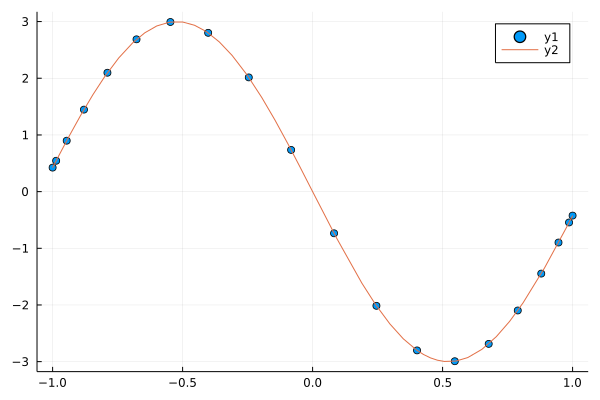

In [216]:
x = CosRange(-1, 1, 20)
T, dT, ddT = chebdiff(x)
c = T \ cos.(3x)
scatter(x, dT * c)
plot!(x -> -3sin(3x))

# Solving a BVP on Chebyshev nodes

In [217]:
function poisson_cheb(n, rhsfunc, leftbc=(0, zero), rightbc=(0, zero))
    x = CosRange(-1, 1, n)
    T, dT, ddT = chebdiff(x)
    L = -ddT
    rhs = rhsfunc.(x)
    for (index, deriv, func) in
            [(1, leftbc...), (n, rightbc...)]
        L[index,:] = (T, dT)[deriv+1][index,:]
        rhs[index] = func(x[index])
    end
    x, L / T, rhs
end

poisson_cheb (generic function with 3 methods)

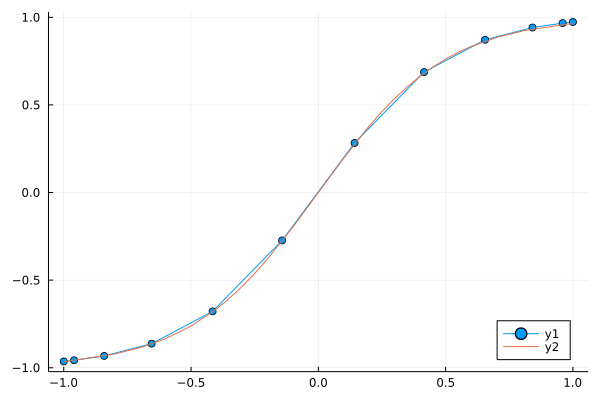

In [220]:
manufactured(x) = tanh(2x)
d_manufactured(x) = 2*cosh(2x)^-2
mdd_manufactured(x) = 8 * tanh(2x) / cosh(2x)^2
x, A, rhs = poisson_cheb(12, mdd_manufactured,
    (0, manufactured), (1, d_manufactured))
plot(x, A \ rhs, marker=:auto)
plot!(manufactured, legend=:bottomright)

# "spectral" (exponential) convergence

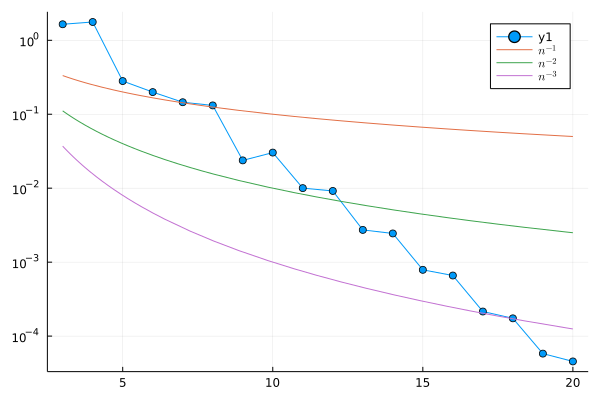

In [223]:
function poisson_error(n)
    x, A, rhs = poisson_cheb(n, mdd_manufactured, (0, manufactured), (1, d_manufactured))
    u = A \ rhs
    norm(u - manufactured.(x), Inf)
end

ns = 3:20
plot(ns, abs.(poisson_error.(ns)), marker=:auto, yscale=:log10)
ps = [1 2 3]
plot!([n -> n^-p for p in ps], label=map(p -> "\$n^{-$p}\$", ps))